In [1]:
# !pip install unsloth

In [2]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print(torch.version.cuda)

Torch version: 2.5.1+cu118
Torchvision version: 0.20.1+cu118
11.8


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

2024-11-12 17:29:57.756770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 17:29:57.756805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 17:29:57.757405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 17:29:57.760804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 17:29:58.179504: W tensorflow/compiler/tf2

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [5]:
data = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)

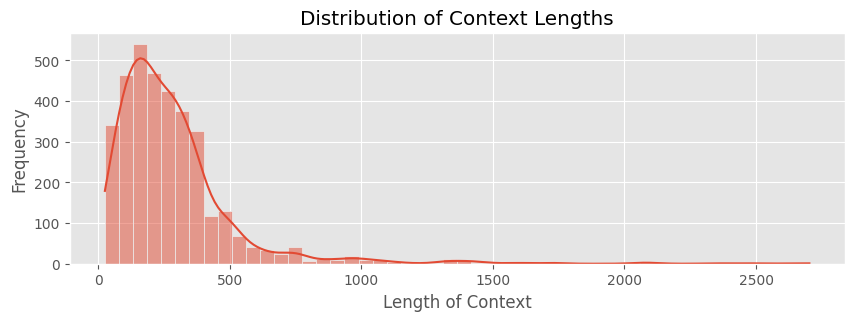

In [6]:
data['Context_length'] = data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [7]:
data

,Context,Response,Context_length
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",328
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",328
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,328
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,328
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,328
...,...,...,...
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...,98
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...,159
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit...",413
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...,356


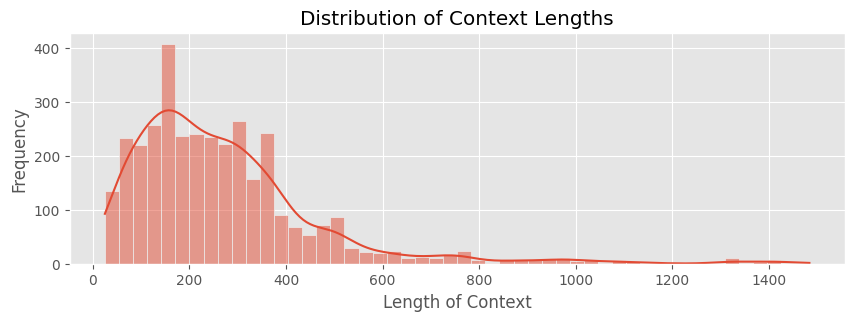

In [8]:
filtered_data = data[data['Context_length'] <= 1500]

ln_Context = filtered_data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

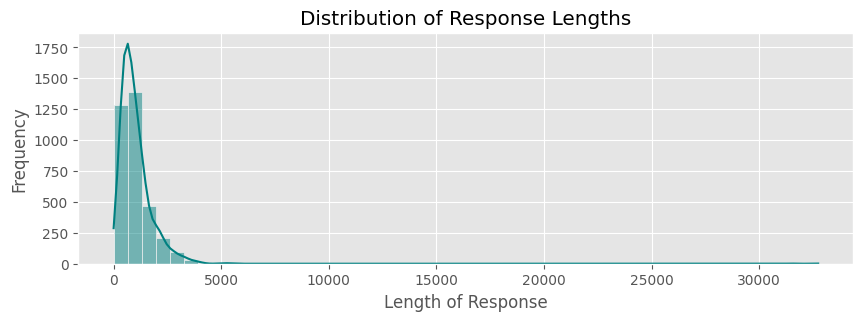

In [9]:
ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

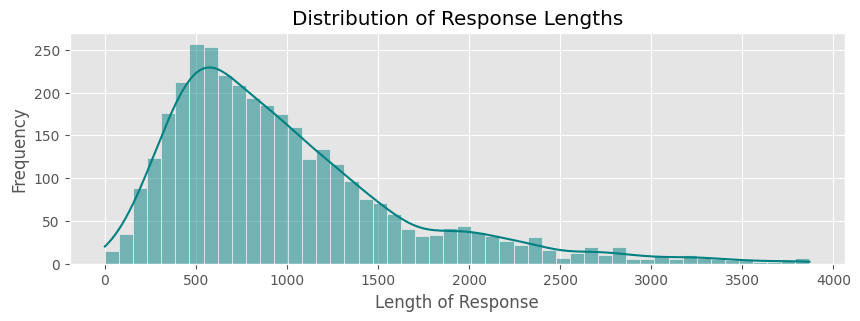

In [10]:
filtered_data = filtered_data[ln_Response <= 4000]

ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

In [11]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
) # 4bit量化, block_size=5020

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())

==((====))==  Unsloth 2024.11.6: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA GeForce RTX 4080 SUPER. Max memory: 15.992 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu118. CUDA = 8.9. CUDA Toolkit = 11.8.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.11.6 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9038820617838861
None


In [12]:
data_prompt = """Analyze the provided text from a mental health perspective. Identify any indicators of emotional distress, coping mechanisms, or psychological well-being. Highlight any potential concerns or positive aspects related to mental health, and provide a brief explanation for each observation.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Context"]
    outputs      = examples["Response"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN # 注意最后要加上EOS
        texts.append(text)
    return { "text" : texts, }

In [13]:
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)

Map:   0%|          | 0/3480 [00:00<?, ? examples/s]

In [14]:
print(training_data[0]['text'])

Analyze the provided text from a mental health perspective. Identify any indicators of emotional distress, coping mechanisms, or psychological well-being. Highlight any potential concerns or positive aspects related to mental health, and provide a brief explanation for each observation.

### Input:
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

### Response:
If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational mess

In [15]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
torch.cuda.empty_cache()

In [16]:
# sudo apt-get update
# sudo apt-get install python3-dev  
# 可能需要安装python开发库

In [17]:
# fp16=not is_bfloat16_supported() and bf16=is_bfloat16_supported(): 
# Enable mixed precision training to reduce memory usage, depending on hardware support.
# 4080super 16G上如果令per_device_train_batch_size>3 就会爆显存
# 通过gradient_accumulation_steps=16来模拟batch_size=48
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=3,
        gradient_accumulation_steps=16,
        num_train_epochs=40,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

In [18]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 227 | Num Epochs = 40
O^O/ \_/ \    Batch size per device = 3 | Gradient Accumulation steps = 16
\        /    Total batch size = 48 | Total steps = 160
 "-____-"     Number of trainable parameters = 11,272,192


Step,Training Loss
1,2.370200
2,2.379800
3,2.352800
4,2.309900
5,4.080200
6,2.222300
7,2.204200
8,2.197400
9,3.948300
10,2.134800


TrainOutput(global_step=160, training_loss=1.4190521730110048, metrics={'train_runtime': 4727.1415, 'train_samples_per_second': 1.921, 'train_steps_per_second': 0.034, 'total_flos': 2.277172171505664e+17, 'train_loss': 1.4190521730110048, 'epoch': 38.18421052631579})

In [19]:
text="I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?"

In [20]:
model = FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    data_prompt.format(
        #instructions
        text,
        #answer
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 5020, use_cache = True)
answer=tokenizer.batch_decode(outputs)
answer = answer[0].split("### Response:")[-1]
print("Answer of the question is:", answer)

Answer of the question is: 
Hello, and thank you for your question. First, I am so glad that you have reached out. If  "I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?" There are so many questions being asked here. Some are questions about yourself, some are questions about your parents, and some are questions about your religion. I won't be able to answer them all. However, I think maybe I can make a beginning. I think maybe this is something that you need to get a check into. I need to know what my options are. I need to know if I'm good or if I'm bad. I need to put my trust in God. I need to stop the negative thoughts. I need to talk to someone. I need help. First, I think you need to talk to someone. You can tal

In [21]:
# os.environ["HF_TOKEN"] = "hugging face token key, you can create from your HF account."
# model.push_to_hub("ImranzamanML/1B_finetuned_llama3.2", use_auth_token=os.getenv("HF_TOKEN"))
# tokenizer.push_to_hub("ImranzamanML/1B_finetuned_llama3.2", use_auth_token=os.getenv("HF_TOKEN"))

In [22]:
model.save_pretrained("model/1B_finetuned_llama3.2")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2")

('model/1B_finetuned_llama3.2/tokenizer_config.json',
 'model/1B_finetuned_llama3.2/special_tokens_map.json',
 'model/1B_finetuned_llama3.2/tokenizer.json')